In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import gaussian
from scipy.ndimage import convolve1d
import peakutils
from peakutils.plot import plot as pplot
import seaborn as sns
import pandas as pd
import pickle
%matplotlib inline

In [63]:
# import some data
filename = 'res/2-14 Traces/2-14_sc_favg_T=1000_N=10.pickle'
with open(filename, 'rb') as handle:
    df = pickle.load(handle)

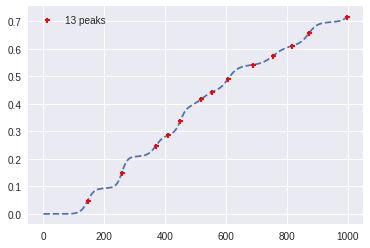

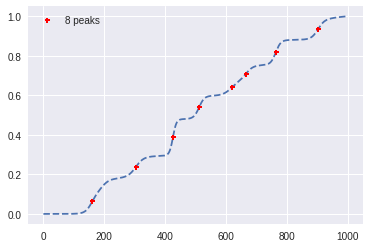

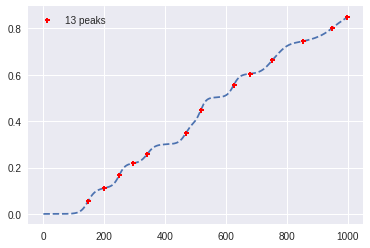

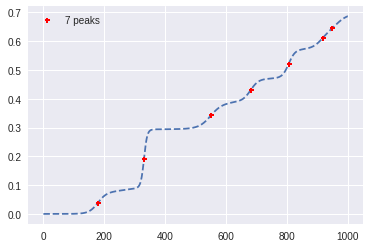

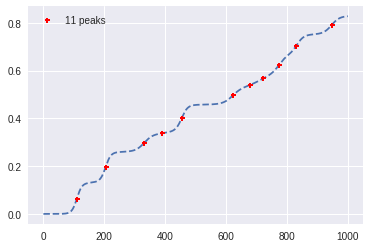

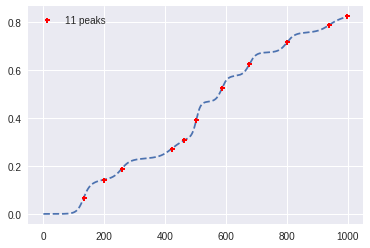

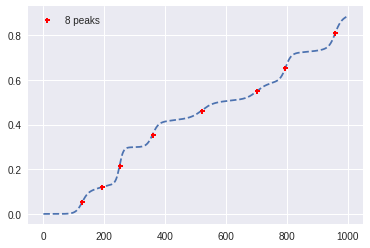

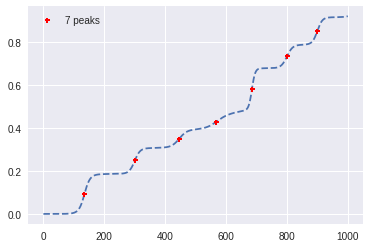

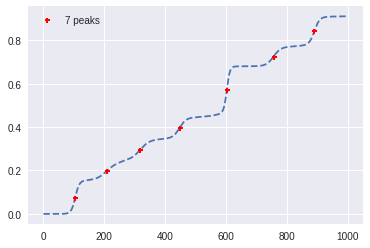

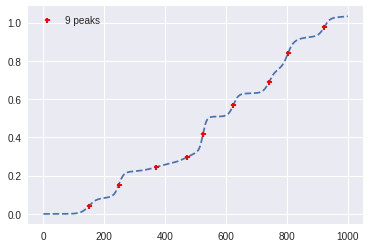

In [64]:
#######################
# Calculate Lag Times #
#######################

# loop over sims
sims = set(df['sim'].values)
t_lag = np.zeros(len(sims))
t_inds = np.zeros(len(t_lag), dtype=int)
for i, sim in enumerate(sims):
    # extract data for this sim
    data = df[df['sim'] == sim]
    t = data['time'].values
    f = data['value'].values
    # smooth with gaussian filter
    gaussian_filter = gaussian(30, 10)
    filtered_signal = convolve1d(f, gaussian_filter/gaussian_filter.sum())
    # calculate first derivative  
    dt = np.diff(t)
    t_avg = (t[1:]+t[:-1])/2
    filt_grad = np.diff(filtered_signal)/dt
    # find peaks
    peak_ind = peakutils.indexes(filt_grad, thres=0.05, min_dist=int(30/dt.mean()))
    # get timestamp for this point
    t_lag[i] = t_avg[peak_ind[0]]
    t_inds[i] = int(peak_ind[0])
    pplot(t, filtered_signal, peak_ind)
    plt.show()

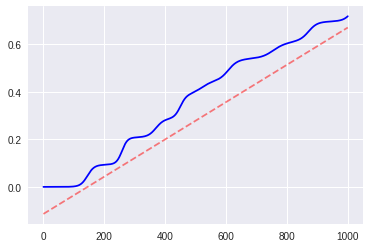

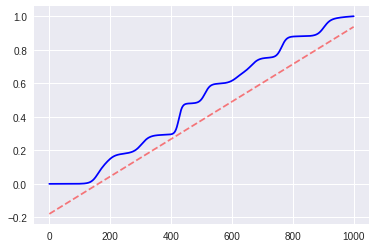

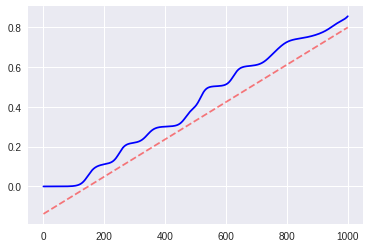

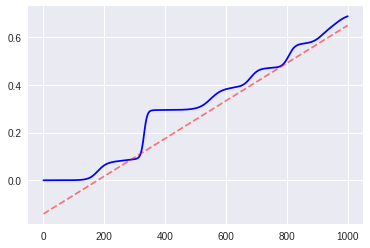

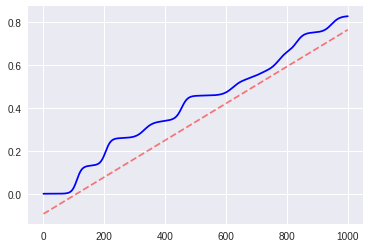

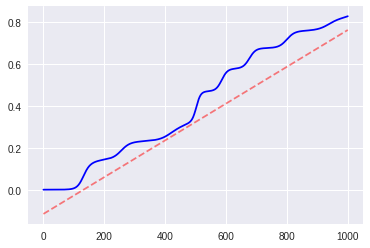

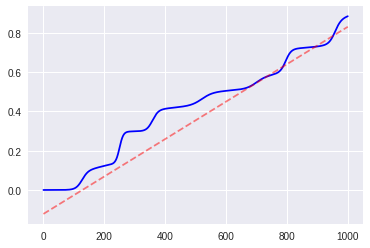

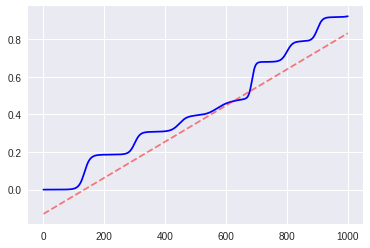

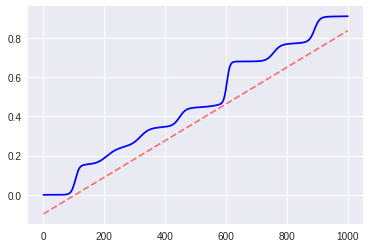

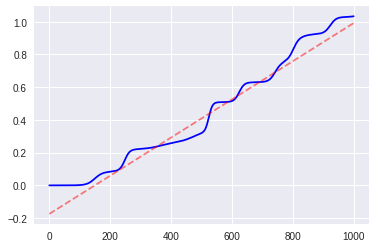

In [65]:
################################
# Calculate Evolutionary Rates #
################################

# loop over sims
sims = set(df['sim'].values)
rates = np.zeros(len(sims))
for i, sim in enumerate(sims):
    # extract data for this sim
    data = df[df['sim'] == sim]
    t = data['time'].values
    f = data['value'].values
    # get estimate for evolutionary rate
    dt = t[-1]  - t[t_inds[i]]
    dx = f[-1] - f[t_inds[i]]
    rates[i] = dx/dt
    # plot estimate against data
    plt.plot(t, f, 'b')
    linear_approx = (dx/dt)*(t - t[t_inds[i]])
    plt.plot(t, linear_approx, '--r', alpha=0.5)
    plt.show()

In [66]:
t_sc = t_lag
r_sc = rates

In [76]:
lag_data = [t_sc]#, t_ff, t_col]
rate_data = [r_sc]#, r_ff, r_col]
codes = ['Standard Code']#, 'Fast Fail', 'Colorado']
dfs = []
for (lags, rates, code) in zip(lag_data, rate_data, codes):
    d = pd.DataFrame({
        't_lag' : lags,
        'rate' : rates,
        'code' : [code for i in range(len(lags))]
    })
    dfs.append(d)
all_data = pd.concat(dfs)

In [77]:
all_data

,code,rate,t_lag
0,Standard Code,0.000785,145.064506
1,Standard Code,0.001116,160.666067
2,Standard Code,0.000935,147.364736
3,Standard Code,0.000790,178.467847
4,Standard Code,0.000858,109.660966
5,Standard Code,0.000876,131.863186
6,Standard Code,0.000953,127.962796
7,Standard Code,0.000961,134.463446
8,Standard Code,0.000934,104.260426
9,Standard Code,0.001166,149.564956


Text(0,0.5,'Lag Time (in generations)')

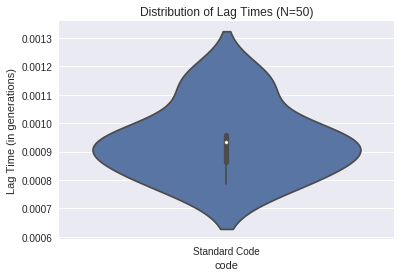

In [79]:
ax = sns.violinplot(x='code', y='rate', data=all_data)
plt.title('Distribution of Lag Times (N=50)')
plt.ylabel('Lag Time (in generations)')
#plt.savefig('bonkers.pdf')